In [ ]:
# default_exp models.transfermodels

# models.transfermodels

> API details.

In [ ]:
# export
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import torch
from torch import nn
from fastrenewables.tabular.model import *
from fastrenewables.timeseries.model import *
from fastai.tabular.all import *
from torch.autograd import Variable
from sklearn.datasets import make_regression
from fastai.learner import *
from fastrenewables.utils_pytorch import *
import copy
from fastrenewables.timeseries.model import *
from fastrenewables.baselines import BayesLinReg
from fastrenewables.tabular.learner import convert_to_tensor
from fastrenewables.losses import *

In [ ]:
def generate_single_dataset(n_samples, start, end, bias, coef, noise_factor=0.3):

    X = np.random.uniform(low=start, high=end,size=n_samples)
    y = np.sin(X*coef*2*np.pi) + np.random.randn(X.shape[0])*noise_factor+bias
    
    return X,y

In [ ]:
def generate_all_tasks(n_samples=100):
    starts = [0,  0]
    ends = [4.1,  3.9]
    coefs = [3.4,  4]
    biases = [0.1,  0.1]
    n_samples = [n_samples, 30]
    
    df_tasks = []
    for task_id in range(len(starts)):
        start, end, bias, coef = starts[task_id], ends[task_id], coefs[task_id], biases[task_id]
        X,y = generate_single_dataset(n_samples[task_id], start, end, bias, coef, noise_factor=0.05)
        df_task = pd.DataFrame({"X": X.ravel(), "y":y.ravel()})
        df_task["TaskID"] = task_id
        df_tasks.append(df_task)
    return pd.concat(df_tasks)

In [ ]:
def get_source_task(df):
    df_source =  df[df.TaskID == 0]
    dls = TabularDataLoaders.from_df(df_source, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    return dls
    
def get_target_task(df):
    df_target =  df[df.TaskID == 1]
    dls = TabularDataLoaders.from_df(df_target, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    return dls

In [ ]:
df = generate_all_tasks()

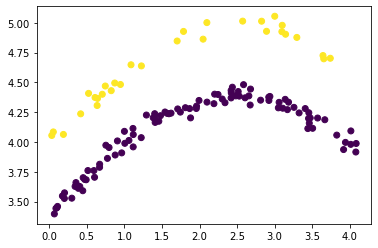

In [ ]:
plt.scatter(df.X, df.y, c=df.TaskID)

In [ ]:
dls_source = get_source_task(df)
dls_target = get_target_task(df)

In [ ]:
set_seed(10)
source_model = MultiLayerPerceptron([1, 100, 10, 5, 1], use_bn=True, bn_cont=False)
learn_source = Learner(dls_source, source_model, metrics=rmse)

In [ ]:
learn_source.fit(25, lr=0.01)

epoch,train_loss,valid_loss,_rmse,time
0,13.439765,12.253729,3.500533,00:00
1,12.763765,10.884159,3.299115,00:00
2,11.984601,9.183905,3.030496,00:00
3,11.035933,7.194599,2.682275,00:00
4,9.889831,5.811112,2.410625,00:00
5,8.585900,3.318880,1.821779,00:00
6,7.224919,1.334587,1.155243,00:00
7,5.928578,0.448196,0.669475,00:00
8,4.808632,0.018519,0.136084,00:00
9,3.915989,0.014090,0.118700,00:00


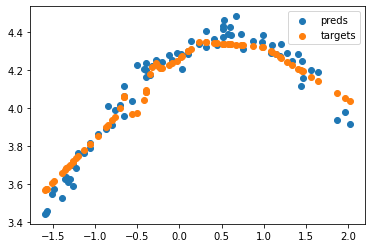

In [ ]:
targets, preds = learn_source.get_preds(ds_idx=0)
plt.scatter(dls_source.train_ds.items.X, preds, label="preds")
plt.scatter(dls_source.train_ds.items.X, targets, label="targets")
plt.legend()
plt.show()

In [ ]:
# hide
# export
def _create_matrices(n_features, alpha):
    w_mean = torch.zeros(n_features)
    w_precision = torch.eye(n_features) / alpha
    
    return w_mean, w_precision
# minimal check if we can create the matricies
mean, precision = _create_matrices(10, 10)
test_eq(0, mean.sum())
test_eq(0.1, precision[0,0])

In [ ]:
# export
class LinearTransferModel(nn.Module):
    def __init__(self, source_model, num_layers_to_remove=1, 
                 name_layers_or_function_to_remove="layers", 
                 use_original_weights=True,
                 prediction_model=BayesLinReg(alpha=1, beta=1, empirical_bayes=False)):
        super().__init__()
        self.are_weights_initialized = False
        self.num_layers_to_remove = num_layers_to_remove
        self.ts_length = 1
        self.source_model = copy.deepcopy(source_model)
        self._prediction_model = prediction_model
        self.prediction_models = []
        if use_original_weights:
            self._prediction_model.empirical_bayes=False
        
        if callable(name_layers_or_function_to_remove):
            name_layers_or_function_to_remove(self.source_model, num_layers_to_remove)
        elif type(name_layers_or_function_to_remove) == str:
            layers = getattrs(self.source_model, name_layers_or_function_to_remove, default=None)[0]
            if layers is None:
                raise ValueError(f"Could not find layers by given name {name_layers_or_function_to_remove}.")
            elif isinstance(layers, torch.nn.modules.container.Sequential):
                setattr(self.source_model, name_layers_or_function_to_remove, layers[0:-self.num_layers_to_remove])
            else:
                raise ValueError(f"Only sequential layers are supported.")
        else:
            ValueError("Unknown type for name_layers_or_function_to_remove")
            
        if num_layers_to_remove != 1 and use_original_weights:
            raise ValueError("Can only reuse weights when using the last layers due to the dimension.")
        elif num_layers_to_remove == 1 and use_original_weights:
            
            for element in layers[-1]:
                if isinstance(element, nn.Linear):
                    # create mean matrix including bias
                    w_mean = copy.copy(element.weight.data)
                    bias = copy.copy(element.bias.data)
                    w_mean = w_mean.reshape(w_mean.shape[1])
                    w_mean = to_np(torch.cat([bias, w_mean]))
                    
                    # create precision and variance matrix
                    self.n_features = w_mean.shape[0]
                    
                    model = self._create_single_model(self.n_features)
                    model.w_mean = w_mean
                    self.prediction_models.append(model)
                    
                    self.are_weights_initialized = True
                    
            if not self.are_weights_initialized:
                raise ValueError(f"Could not find linear layer in last layer {self.layers[-1]}")
        
        
        freeze(self.source_model)
        
        # fake param so that it can be used with pytorch trainers
        self.fake_param=nn.Parameter(torch.zeros((1,1), dtype=torch.float))
        self.fake_param.requires_grad =True
        
    def _create_single_model(self,n_features):
        model = copy.copy(self._prediction_model)
        model._create_matrices(np.ones(n_features).reshape(1, n_features))
        model.w_covariance = np.linalg.inv(model.w_precision)
        return model
        
        
    @property
    def alpha(self):
        return self._prediction_model.alpha
    
    @property
    def beta(self):
        return self._prediction_model.beta
    
    @alpha.setter
    def alpha(self, alpha):
        self._prediction_model.alpha = alpha
        
    @beta.setter
    def beta(self, beta):
        self._prediction_model.beta = beta
        
    def correct_shape(self, x):
        n_samples = x.shape[0]
        return x.reshape(n_samples, -1)
        
    def transform(self, cats, conts, as_np=False):
        x_transformed =  self.source_model(cats, conts)
        
        x_transformed = self.correct_shape(x_transformed)
        
        if as_np: return to_np(x_transformed)
        else: return x_transformed
    
    def forward(self, cats, conts):
        n_samples = conts.shape[0]
        self.ts_length = 1
        if len(conts.shape) == 3:
            self.ts_length = conts.shape[2]
        
        x_transformed = self.transform(cats, conts) 
        
        if not self.are_weights_initialized:
            self.n_features = x_transformed.shape[1]+1
            
            for idx in range(self.ts_length):
                model = self._create_single_model(self.n_features)
                self.prediction_models.append(model)
                    
            self.are_weights_initialized=True
        
        if self.training:
            return x_transformed
        else:
            preds = self.pred_transformed_X(x_transformed)
            
            return preds
            
    def update(self, X, y):
        X = to_np(X)
        y = to_np(y)
        y = self.correct_shape(y)
        
        for idx, prediction_model in enumerate(self.prediction_models):
            prediction_model.fit(X, y[:,idx].ravel())
        
        return self

    def predict(self, cats, conts):
        x_transformed = self.transform(cats, conts, as_np=True) 
        return self.pred_transformed_X(x_transformed)

    def predict_proba(self, cats, conts):
        x_transformed = self.transform(cats, conts, as_np=True)
        return self.pred_transformed_X(x_transformed, include_std=True)
    
    def pred_transformed_X(self, x_transformed, include_std=False):
        y_pred_means = np.zeros((len(x_transformed), len(self.prediction_models)))
        y_pred_stds = np.zeros((len(x_transformed), len(self.prediction_models)))
        
        for idx, prediction_model in enumerate(self.prediction_models):
            y_pred_mean, y_pred_std = prediction_model.predict_proba(x_transformed)
            y_pred_means[:,idx] = y_pred_mean
            y_pred_stds[:,idx] = y_pred_std
        if include_std:
            return torch.tensor(y_pred_means, dtype=torch.float32), torch.tensor(y_pred_stds, dtype=torch.float32),
        else:
            return torch.tensor(y_pred_means, dtype=torch.float32)
    
    def loss_func(self, x_transformed, ys):
        ys = self.correct_shape(ys)
        if self.training:
            self.update(x_transformed, ys)
        
            fake_loss = torch.tensor([0], dtype=torch.float)
            fake_loss.requires_grad=True
            return self.fake_param + fake_loss
        else:
            # in case of validation return MSE
            return ((x_transformed-ys)**2).mean()
        
    def log_posterior(self, cats, conts, ys):
        ys = to_np(self.correct_shape(ys))
        
        x_transformed = self.transform(cats, conts, as_np=True) 
      
        posteriors = np.zeros((len(self.prediction_models),1))
        for idx, pred_model in enumerate(self.prediction_models):
            log_posterior = pred_model.log_posterior(x_transformed, ys[:,idx].ravel())
            posteriors[idx] = log_posterior
        return posteriors
        
    def log_evidence(self, cats, conts, ys, logme=False):
        evidences = []
        ys = to_np(self.correct_shape(ys))
        
        x_transformed = self.transform(cats, conts, as_np=True) 
        for idx, pred_model in enumerate(self.prediction_models):
            ev = pred_model.log_evidence(x_transformed, ys[:,idx].ravel())
            evidences.append(ev)
            
        evidences = np.array(evidences, dtype=np.float)
        
        if logme:
            evidences = evidences / len(conts)
        
        return evidences.mean()

In [ ]:
# hide
cats, conts, targets = dls_target.one_batch()
# test if we get the same results as with the original model
with torch.no_grad():
    
    preds_source = source_model(cats, conts)
    ltmodel = LinearTransferModel(source_model, num_layers_to_remove=1, use_original_weights=True)
    
    preds_target = ltmodel.predict(cats, conts)
    test_close(preds_source, preds_target)
    preds_target = ltmodel.predict(cats, conts)
    test_close(preds_source, preds_target)
    preds_target = ltmodel.predict_proba(cats, conts)[0]
    test_close(preds_source, preds_target)


# Synthetic data

## Linear Transfer Model

In [ ]:
target_model = LinearTransferModel(source_model, num_layers_to_remove=1, 
                                   use_original_weights=True,
                                  )
target_model = target_model.eval()

Create forecats and check if the source model and the untrained model create the same results

In [ ]:
cats, conts, targets = dls_source.one_batch()

In [ ]:
with torch.no_grad():
    preds_source = source_model(cats, conts).ravel()
preds_target = target_model(cats.to("cpu"), conts.to("cpu"))

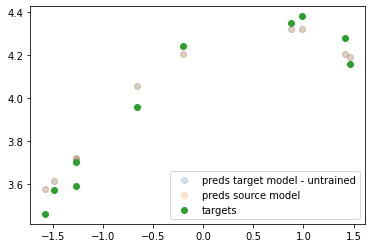

In [ ]:
# targets, preds = learn_source.get_preds(ds_idx=0)
plt.scatter(conts, preds_target, label="preds target model - untrained", alpha=0.2)
plt.scatter(conts, preds_source.detach(), label="preds source model", alpha=0.2)
plt.scatter(conts, targets, label="targets")

plt.legend()
plt.show()

In [ ]:
target_model = LinearTransferModel(source_model, num_layers_to_remove=1, 
                                   use_original_weights=True,
                                   )
target_model.training = True

In [ ]:
cats, conts, targets = convert_to_tensor(dls_target.train_ds)
preds_before_training = target_model.predict(cats, conts)

In [ ]:
x_transformed = target_model.forward(cats, conts)
target_model = target_model.update(x_transformed, targets.ravel())
target_model.training = False
preds_after_training = target_model.forward(cats, conts)

In [ ]:
((targets.reshape(-1)-preds_after_training.reshape(-1))**2).mean()**0.5

tensor(0.0808)

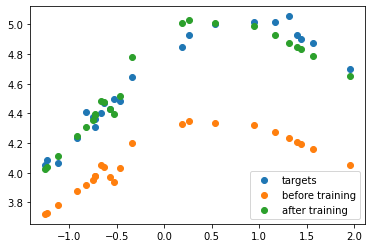

In [ ]:
plt.scatter(conts, targets, label="targets")
plt.scatter(conts, preds_before_training, label="before training")
plt.scatter(conts, preds_after_training, label="after training")
plt.legend()

Lets assure that it also works with pytorch trainings such as the fastai training loop

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=1, 
                                   use_original_weights=True,
                                   )

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=1, 
                                   use_original_weights=True,
                                   )


target_learner = Learner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.000505,0.022362,0.149539,00:00


We can also not using the last layer as initializaition

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=1, 
                                   use_original_weights=False,
                                   prediction_model=BayesLinReg(alpha=1, beta=1, empirical_bayes=False))


target_learner = Learner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.000505,0.059818,0.244578,00:00


Due to the few data samples, the empircal bayes is not working well.

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=1, 
                                   use_original_weights=False,
                                   prediction_model=BayesLinReg(alpha=1, beta=1, empirical_bayes=True))


target_learner = Learner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.000505,0.026540,0.162911,00:00


Or remove multiple layers

In [ ]:
target_model = LinearTransferModel(source_model, 
                                   num_layers_to_remove=2, 
                                   use_original_weights=False,
                                   prediction_model=BayesLinReg(alpha=10, beta=10, empirical_bayes=False)
                                   )


target_learner = Learner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.000505,0.198540,0.445578,00:00


## B Tuning

In [ ]:
#export

class BTuningModel(nn.Module):
    def __init__(self, source_model, b_tuning_models):
        """Based on Ranking and Tuning Pre-trained Models: A New Paradigm of Exploiting Model Hubs"""
        super().__init__()
        self.source_model = source_model
        self.b_tuning_models = b_tuning_models
        
        for model in self.b_tuning_models:
            model.fake_param.requires_grad=False
            model.eval()
            
    def forward(self, cats, conts):
        yhat_source_model = self.source_model(cats, conts)
        yhat_b_tuning_models = []
        n_samples = len(conts)
        is_ts = True if len(yhat_source_model.shape) == 3 else False
        for b_tuning_model in self.b_tuning_models:
            cur_y_hat = b_tuning_model(cats, conts)
            if is_ts:
                cur_y_hat = cur_y_hat.reshape(n_samples, 1, -1)
            yhat_b_tuning_models.append(cur_y_hat)
        yhat_b_tuning_models = torch.cat(yhat_b_tuning_models, axis=1)
        # if is_ts and len(yhat_b_tuning_models.shape) == 2:
        #     yhat_b_tuning_models = yhat_b_tuning_models[:, np.newaxis, :]

        yhat_all = torch.cat([yhat_source_model, yhat_b_tuning_models], axis=1)
        
        return yhat_all
            

# Test on real world data

## MLP

In [ ]:

from fastrenewables.tabular.core import *
from fastrenewables.tabular.data import *
from fastrenewables.tabular.model import *
from fastrenewables.tabular.learner import *

In [ ]:
cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
       'ASWDIRS_SFC_0_M', 'WindSpeed58m',
       'SinWindDirection58m', 'CosWindDirection58m', 'WindSpeed60m',
       'SinWindDirection60m', 'CosWindDirection60m', 'WindSpeed58mMinus_t_1',
       'SinWindDirection58mMinus_t_1', 'CosWindDirection58mMinus_t_1',
       'WindSpeed60mMinus_t_1', 'SinWindDirection60mMinus_t_1',
       'CosWindDirection60mMinus_t_1', 'WindSpeed58mPlus_t_1',
       'SinWindDirection58mPlus_t_1', 'CosWindDirection58mPlus_t_1',
       'WindSpeed60mPlus_t_1', 'SinWindDirection60mPlus_t_1',
       'CosWindDirection60mPlus_t_1']
cat_names = ['TaskID', 'Month', 'Day', 'Hour']
set_seed(23, reproducible=True)
dls_source = RenewableDataLoaders.from_files(glob.glob("../data/*.h5")[0], y_names="PowerGeneration", 
                                      pre_procs=[FilterYear(year=2020), 
                                                 AddSeasonalFeatures(as_cont=False)], 
                                      cat_names=cat_names, cont_names=cont_names)
dls_source2 = RenewableDataLoaders.from_files(glob.glob("../data/*.h5")[1], y_names="PowerGeneration", 
                                      pre_procs=[FilterYear(year=2020), 
                                                 AddSeasonalFeatures(as_cont=False)], 
                                      cat_names=cat_names, cont_names=cont_names)

dls_target = RenewableDataLoaders.from_files(glob.glob("../data/*.h5")[2], y_names="PowerGeneration", 
                                      pre_procs=[FilterYear(year=2020), 
                                                 FilterMonths(months=[4]),
                                                 FilterDays(14),
                                                 AddSeasonalFeatures(as_cont=False)], 
                                      cat_names=cat_names, cont_names=cont_names)

dls_target_test = RenewableDataLoaders.from_files(glob.glob("../data/*.h5")[2], y_names="PowerGeneration", 
                                      pre_procs=[FilterYear(year=2020, drop=False), 
                                                 AddSeasonalFeatures(as_cont=False)], 
                                      cat_names=cat_names, cont_names=cont_names)

In [ ]:
learn_source = renewable_learner(dls_source, metrics=rmse)
learn_source.fit_one_cycle(5)

epoch,train_loss,valid_loss,_rmse,time
0,0.060764,0.025127,0.158516,00:00
1,0.024576,0.013699,0.117044,00:01
2,0.017317,0.014669,0.121117,00:01
3,0.013764,0.011669,0.108023,00:01
4,0.012156,0.010285,0.101414,00:00


In [ ]:
learn_source2 = renewable_learner(dls_source2, metrics=rmse)
learn_source2.fit_one_cycle(5)

epoch,train_loss,valid_loss,_rmse,time
0,0.054225,0.021796,0.147634,00:01
1,0.023602,0.014269,0.119451,00:00
2,0.016183,0.013391,0.115718,00:00
3,0.013117,0.013346,0.115527,00:00
4,0.012015,0.011931,0.109227,00:00


When using empirical bayes (MacKay or FixedPoint) we need to set the size of a batch equal to the length  of the complete data. As these algorithms are not supporting a batch wise optimization.

In [ ]:
target_model = LinearTransferModel(learn_source.model, 1, 
                                   use_original_weights=True,
                                  prediction_model=BayesLinReg(alpha=10, beta=10, empirical_bayes=False))
target_learner = RenewableLearner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.001525,0.010598,0.102948,00:00


In [ ]:
preds, targets = target_learner.predict(ds_idx=1, filter=True, flatten=True)

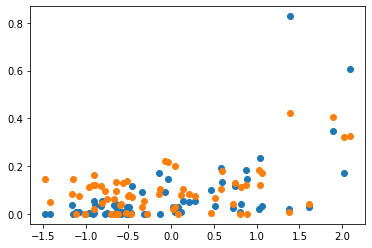

In [ ]:
plt.scatter(dls_target.valid_ds.items.WindSpeed58m, targets)
plt.scatter(dls_target.valid_ds.items.WindSpeed58m, preds)

In [ ]:
target_model = LinearTransferModel(learn_source.model, 1, 
                                   use_original_weights=True,
            prediction_model=BayesLinReg(alpha=10, beta=10, empirical_bayes=True))
target_learner = RenewableLearner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.dls[0].bs=len(target_learner.dls.train_ds)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,0.000000,0.011052,0.105130,00:00


In [ ]:
target_model2 = LinearTransferModel(learn_source2.model, 1, 
                                   use_original_weights=True,
            prediction_model=BayesLinReg(alpha=10, beta=10, empirical_bayes=True))
target_learner = RenewableLearner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.dls[0].bs=len(target_learner.dls.train_ds)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.001000,0.011031,0.105027,00:00


## B Tunning 

In [ ]:
target_learner = RenewableLearner(dls_target, copy.deepcopy(learn_source.model), metrics=rmse)
target_learner.fit(5, lr=5e-4)
preds, targets = target_learner.predict(test_dl=dls_target_test, filter=False, flatten=False)
((targets.ravel()-preds.ravel())**2).mean()**0.5

epoch,train_loss,valid_loss,_rmse,time
0,0.015581,0.013645,0.116811,00:00
1,0.014094,0.010160,0.100795,00:00
2,0.012321,0.009292,0.096397,00:00
3,0.011074,0.008810,0.093862,00:00
4,0.010008,0.009280,0.096335,00:00


0.1466360260837255

In [ ]:
dls_target_test

In [ ]:
source_model = copy.deepcopy(learn_source.model)
btuning_model = BTuningModel(source_model, [target_model,target_model2])
btuning_loss = BTuningLoss(lambd=1)


target_learner = RenewableLearner(dls_target, btuning_model, loss_func=btuning_loss, metrics=btuning_rmse)
preds, targets = target_learner.predict(test_dl=dls_target_test, filter=False, flatten=False)
print(btuning_rmse(preds, targets))

target_learner.fit(5, lr=5e-4)
preds, targets = target_learner.predict(test_dl=dls_target_test, filter=False, flatten=False)
btuning_rmse(preds, targets)

0.14171423540000816


epoch,train_loss,valid_loss,btuning_rmse,time
0,0.029112,0.028083,0.113513,00:00
1,0.028177,0.021970,0.098327,00:00
2,0.025341,0.021795,0.099479,00:00
3,0.023564,0.021233,0.098929,00:00
4,0.022025,0.021831,0.100262,00:00


0.14397981843449878

## TCN

### Source Model

In [ ]:
from fastrenewables.timeseries.core import *
from fastrenewables.tabular.core import *
from fastrenewables.timeseries.data import *
from fastrenewables.timeseries.model import *
from fastrenewables.timeseries.learner import *

In [ ]:
def get_dls(y_names="PowerGeneration"):
    pd.options.mode.chained_assignment=None
    dls_source = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[0:1], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[CreateTimeStampIndex(index_col_name="TimeUTC"),
                                                           FilterYear(year=2020), 
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    
    dls_target = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[2], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[CreateTimeStampIndex(index_col_name="TimeUTC"),
                                                           FilterYear(year=2020), 
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay, 
                                                           FilterMonths(months=[1,2,3,4])], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    
    dls_target_test = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[2], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[CreateTimeStampIndex(index_col_name="TimeUTC"),
                                                           FilterYear(year=2020, drop=False), 
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay, 
                                                           FilterMonths(months=[1,2,3,4])], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    return dls_source, dls_target,dls_target_test



In [ ]:
set_seed(23, reproducible=True)
dls_source, dls_target, dls_target_test = get_dls()

In [ ]:
n_features = len(dls_source.train_ds.cont_names)

In [ ]:
learner = renewable_timeseries_learner(dls_source, metrics=rmse, layers=[n_features, 200, 100, 50, 25, 5, 1])

In [ ]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,_rmse,time
0,0.031414,0.015584,0.124834,00:00
1,0.022274,0.014412,0.120049,00:00
2,0.018172,0.012712,0.112750,00:00
3,0.015774,0.012098,0.109992,00:00
4,0.014208,0.011923,0.109195,00:00


In [ ]:
preds, targets = learner.predict(ds_idx=1, filter=True)

In [ ]:
id_ws = 5

We catch the the wind speed from the validation data to check the forecasts.

In [ ]:
windspeed = dls_source.valid_ds.conts[:,id_ws,:]
windspeed = windspeed.reshape(-1,1)

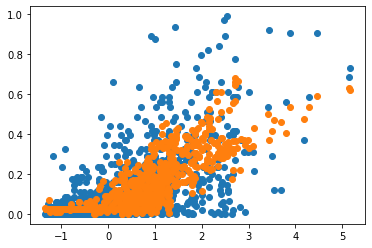

In [ ]:
plt.scatter(windspeed, targets)
plt.scatter(windspeed, preds)

### Target Model

In [ ]:
# export
def reduce_layers_tcn_model(tcn_model, num_layers=0):
    tcn_model.layers.temporal_blocks = tcn_model.layers.temporal_blocks[:-num_layers]

The problem is that we have a lot of features while less samples compared to the linear model.

In [ ]:
target_model = LinearTransferModel(learner.model, 1, 
                                   reduce_layers_tcn_model, 
                                   use_original_weights=False,
                prediction_model=BayesLinReg(10, 10, empirical_bayes=False),
                                  )

In [ ]:
target_learner = RenewableTimeseriesLearner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,-0.003606,0.019469,0.139532,00:00


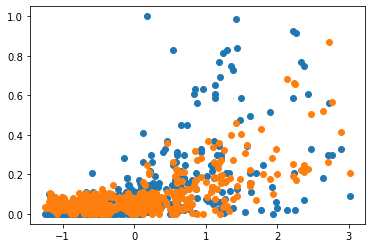

In [ ]:
preds, targets = target_learner.predict(ds_idx=1, filter=True, flatten=True)
windspeed = dls_target.valid_ds.conts[:,id_ws,:]
windspeed = windspeed.reshape(-1,1)
plt.scatter(windspeed, targets)
plt.scatter(windspeed, preds)

In [ ]:
cats, conts, ys = convert_to_tensor_ts(dls_target.train_ds)

In [ ]:
target_model.log_posterior(cats, conts, ys).shape

(24, 1)

In [ ]:
target_model = LinearTransferModel(learner.model, 1, 
                                   reduce_layers_tcn_model, 
                                   use_original_weights=False,
                        prediction_model=BayesLinReg(1, 1, empirical_bayes=True),
                                  )

target_learner = RenewableTimeseriesLearner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.dls[0].bs=len(target_learner.dls.train_ds)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,0.000000,0.063167,0.251331,00:00


In [ ]:
target_model = LinearTransferModel(learner.model, 1, 
                       reduce_layers_tcn_model, 
                       use_original_weights=False,
                        prediction_model=BayesLinReg(1, 1, use_fixed_point=True),
                                  )

target_learner = RenewableTimeseriesLearner(dls_target, target_model, loss_func=target_model.loss_func, metrics=rmse,)
target_learner.dls[0].bs=len(target_learner.dls.train_ds)
target_learner.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,0.000000,0.017801,0.133420,00:00


In [ ]:
preds, targets = target_learner.predict(test_dl=dls_target_test)
((targets-preds)**2).mean()**0.5

0.1767454669919444

In [ ]:
preds, targets = target_learner.predict(ds_idx=1, filter=True, flatten=True)
windspeed = dls_target.valid_ds.conts[:,id_ws,:]

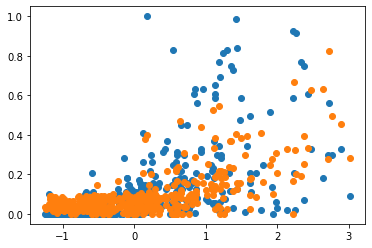

In [ ]:
windspeed = dls_target.valid_ds.conts[:,id_ws,:]
windspeed = windspeed.reshape(-1,1)
plt.scatter(windspeed.ravel(), targets)
plt.scatter(windspeed.ravel(), preds)

In [ ]:
source_model = copy.deepcopy(learner.model)
btuning_model = BTuningModel(source_model, [target_model])
btuning_loss = BTuningLoss(lambd=1)

target_learner = RenewableTimeseriesLearner(dls_target, btuning_model, loss_func=btuning_loss, metrics=btuning_rmse)
preds, targets = target_learner.predict(test_dl=dls_target_test, filter=False, flatten=False)
print(btuning_rmse(preds, targets))

target_learner.fit(5, lr=5e-4)
preds, targets = target_learner.predict(test_dl=dls_target_test, filter=False, flatten=False)
btuning_rmse(preds, targets)

0.15673371780739934


epoch,train_loss,valid_loss,btuning_rmse,time
0,0.025212,0.018195,0.116221,00:00
1,0.024514,0.018251,0.114272,00:00
2,0.023602,0.018703,0.116746,00:00
3,0.022872,0.019085,0.118390,00:00
4,0.022434,0.018948,0.117193,00:00


0.146978707680052